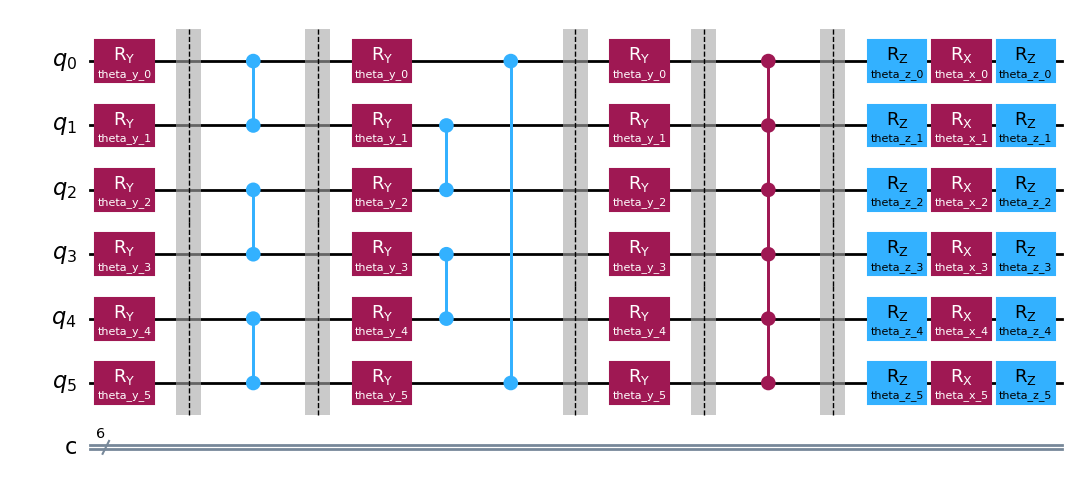

In [1]:
from qiskit import QuantumCircuit, transpile 
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit.circuit.library import MCMT
import numpy as np
from matplotlib import pyplot as plt

# Số qubit
n = 6

# Định nghĩa các tham số cho các cổng xoay Rx, Ry, Rz cho từng qubit
params_x = [Parameter(f'theta_x_{i}') for i in range(n)]
params_y = [Parameter(f'theta_y_{i}') for i in range(n)]
params_z = [Parameter(f'theta_z_{i}') for i in range(n)]

# Tạo mạch lượng tử
qc = QuantumCircuit(n, n)

# Phần |g₂⟩: Sử dụng cổng Ry và CZ
for i in range(n):
    qc.ry(params_y[i], i)

qc.barrier()
i = 0
while i < n - 1:
    qc.cz(i, i + 1)
    i += 2

qc.barrier()
for i in range(n):
    qc.ry(params_y[i], i)

j = 1
while j < n - 1:
    qc.cz(j, j + 1)
    j += 2

qc.cz(n - 1, 0)  # Kết nối qubit cuối với qubit đầu tiên
qc.barrier()

# Phần |gₙ⟩: Sử dụng cổng Ry
for i in range(n):
    qc.ry(params_y[i], i)

qc.barrier()

# Thêm cổng MCMT CZ cho |gₙ⟩
mcmt_circuit = MCMT('cz', (n - 1), 1)
qc = qc.compose(mcmt_circuit, qubits=range(n))

qc.barrier()

# Phần W: Sử dụng cổng Rz và Rx
for i in range(n):
    qc.rz(params_z[i], i)
    qc.rx(params_x[i], i)
    qc.rz(params_z[i], i)

qc.draw('mpl')

In [2]:
# Hàm tính xác suất đo trạng thái |1> trên qubit đầu tiên
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram

basis_gates=['u3', 'cx']
def loss(qc, params, n):
    qc.measure(0, 0)
    qc=qc.assign_parameters(params)
    transpiled_qc = transpile(qc,basis_gates=basis_gates)  
    backend = BasicProvider().get_backend('basic_simulator')
    result = backend.run (transpiled_qc, shots=1000).result()
    counts = result.get_counts()
  
    decimal_counts = {}
    for key, value in counts.items():
        decimal_key = int(key, 2)  # Chuyển đổi chuỗi nhị phân thành số thập phân
        decimal_counts[decimal_key] = value

    # Xác suất đo trạng thái |1> trên qubit đầu tiên
    p1 = decimal_counts.get(1, 0) / 1000
    return p1

In [3]:
# Hàm tính gradient sử dụng parameter-shift rule
def parameter_shift_gradient(qc, params, param_key):
    shift = np.pi / 2
    # Tạo các bộ giá trị tham số với độ lệch
    params_plus = params.copy()
    params_minus = params.copy()
    params_plus[param_key] += shift
    params_minus[param_key] -= shift
    # Tính gradient
    grad = 0.5 * (loss(qc, params_plus, n) - loss(qc, params_minus, n))
    return grad

In [4]:
# Khởi tạo giá trị tham số
param_values = np.random.uniform(0, 2 * np.pi, len(params_x) + len(params_y) + len(params_z))
learning_rate = 0.3
params = dict(zip(params_x + params_y + params_z, param_values))

In [5]:
# Tối ưu hóa tham số để kết quả đo trên dây đầu tiên là |0>
losses = []
for epoch in range(100):
    grads = {key: parameter_shift_gradient(qc, params, key) for key in params}
    # Cập nhật tham số
    for key, grad in grads.items():
        params[key] -= learning_rate * grad
    
    current_loss = loss(qc, list(params.values()), n)
    losses.append(current_loss)
    print(f"Epoch {epoch + 1}: Loss = {current_loss:.4f}")
    # Dừng nếu Loss gần 0
    if current_loss < 1e-1:
        break

Epoch 1: Loss = 0.5260
Epoch 2: Loss = 0.3940
Epoch 3: Loss = 0.3040
Epoch 4: Loss = 0.2080
Epoch 5: Loss = 0.1310
Epoch 6: Loss = 0.0880



Các tham số tối ưu trên mạch:

Qubit 0:
  Ry: theta_y_0 = 5.8376
  Rz: theta_z_0 = 2.4597
  Rx: theta_x_0 = 0.1909

Qubit 1:
  Ry: theta_y_1 = 3.1717
  Rz: theta_z_1 = 4.2020
  Rx: theta_x_1 = 1.6594

Qubit 2:
  Ry: theta_y_2 = 0.0075
  Rz: theta_z_2 = 5.3310
  Rx: theta_x_2 = 3.9027

Qubit 3:
  Ry: theta_y_3 = 2.6779
  Rz: theta_z_3 = 5.9883
  Rx: theta_x_3 = 1.7591

Qubit 4:
  Ry: theta_y_4 = 5.3582
  Rz: theta_z_4 = 2.8280
  Rx: theta_x_4 = 4.1847

Qubit 5:
  Ry: theta_y_5 = 5.4252
  Rz: theta_z_5 = 3.6735
  Rx: theta_x_5 = 1.7814

Mạch lượng tử sau khi gán tham số:


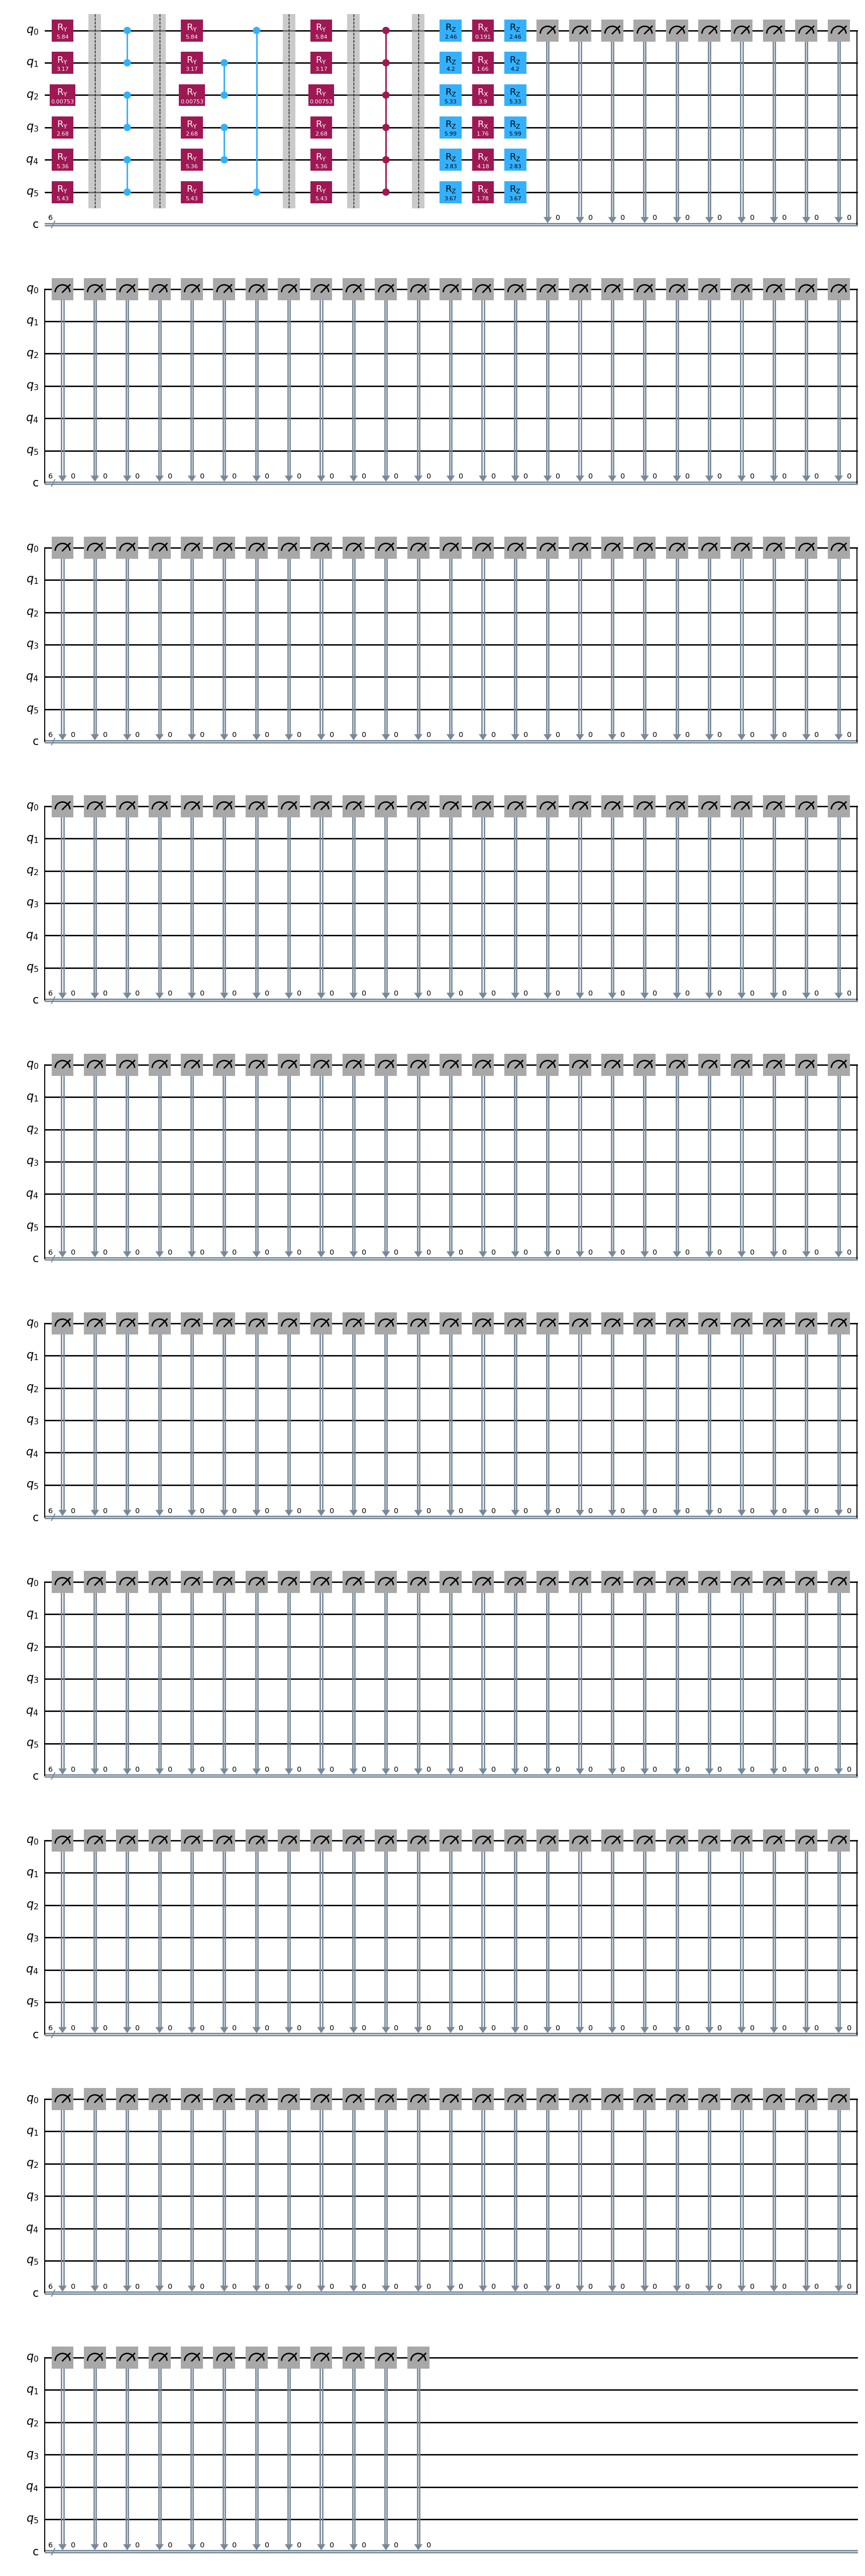

In [6]:
# Các tham số sau khi tối ưu hóa
print("\nCác tham số tối ưu trên mạch:")
for i in range(n):
    print(f"\nQubit {i}:")
    print(f"  Ry: theta_y_{i} = {params[params_y[i]]:.4f}")
    print(f"  Rz: theta_z_{i} = {params[params_z[i]]:.4f}")
    print(f"  Rx: theta_x_{i} = {params[params_x[i]]:.4f}")

# Hiển thị mạch với các tham số đã được gán
final_qc = qc.assign_parameters({param: value for param, value in params.items()})
print("\nMạch lượng tử sau khi gán tham số:")
final_qc.draw('mpl')


In [15]:


# Hàm tính xác suất đo trạng thái |1> trên qubit đầu tiên
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram

basis_gates=['u3', 'cx']
def measure(final_qc, params, n):
    final_qc.measure(0, 0)
    transpiled_qc = transpile(final_qc,basis_gates=basis_gates)  
    backend = BasicProvider().get_backend('basic_simulator')
    result = backend.run (transpiled_qc, shots=1000).result()
    counts = result.get_counts()
  
    decimal_counts = {}
    for key, value in counts.items():
        decimal_key = int(key, 2)  # Chuyển đổi chuỗi nhị phân thành số thập phân
        decimal_counts[decimal_key] = value

    # # Xác suất đo trạng thái |1> trên qubit đầu tiên
    # p1 = decimal_counts.get(1, 0) / 1000
    return decimal_counts


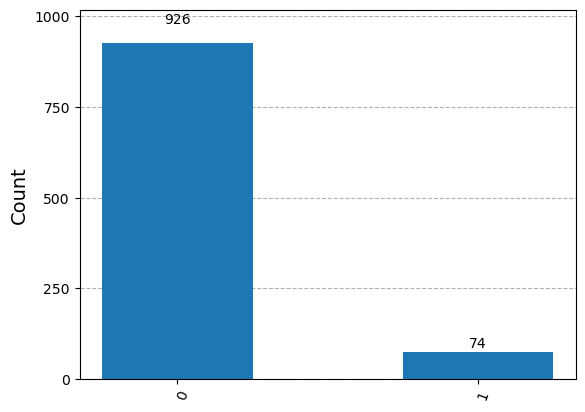

In [16]:
plot_histogram(measure(final_qc, params, n))


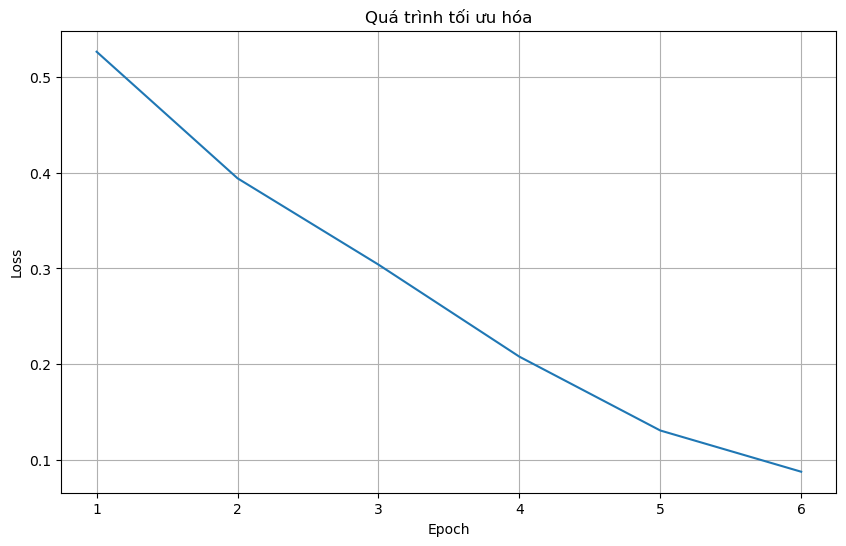

In [17]:
# Hiển thị kết quả training bằng đồ thị matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses)
plt.title('Quá trình tối ưu hóa')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()